# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
from sklearn.datasets import load_boston

In [5]:
boston = load_boston()

C:\Users\obars\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset 

In [6]:
X = boston["data"]
y = boston["target"]

In [7]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [8]:
def compute_biase_variance(clf, X, y, num_runs=1000):
    predictions = pd.DataFrame(index=np.arange(X.shape[0]), columns=np.arange(num_runs))

    for i in range(num_runs):
        idx = np.random.choice(np.arange(X.shape[0]), 
                              size=X.shape[0], replace=True)
        clf.fit(X[idx], y[idx])
        outofbag_idx = np.array(list(set(np.arange(X.shape[0])).difference(set(idx))))
        predictions[i][outofbag_idx] = clf.predict(X[outofbag_idx])

    predictions['Num_OOB']=(num_runs-np.sum(predictions.isna(), axis=1))    
    avg_model = predictions.sum(axis=1)/predictions['Num_OOB']
    predictions['AVG_Model']=pd.DataFrame(avg_model.values)
    predictions['sum_delta'] = 0
    predictions['error'] = 0

    for i in range(num_runs):
        delta = (predictions[i] - predictions['AVG_Model'])**2
        predictions['sum_delta'] = predictions['sum_delta'] + delta.fillna(0)
        error = (predictions[i] - y)**2
        predictions['error'] = predictions['error'] + error.fillna(0)

    variance = sum(predictions['sum_delta']/(predictions['Num_OOB']-1))/X.shape[0]
    bias = sum((predictions['AVG_Model'] - y)**2)/X.shape[0]
    L_error = sum(predictions['error']/predictions['Num_OOB'])/X.shape[0]
    return round(bias, 2), round(variance, 2), round(L_error, 2)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
bias, variance, error = compute_biase_variance(lr, X, y)
print('Bias = {}, variance = {}, L_Error = {}'.format(bias, variance, error))

Bias = 24.59, variance = 1.94, L_Error = 24.62


In [10]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
bias, variance, error = compute_biase_variance(tree, X, y)
print('Bias = {}, variance = {}, L_Error = {}'.format(bias, variance, error))

Bias = 11.18, variance = 14.14, L_Error = 23.28


In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
bias, variance, error = compute_biase_variance(rf, X, y)
print('Bias = {}, variance = {}, L_Error = {}'.format(bias, variance, error))

Bias = 11.55, variance = 4.37, L_Error = 13.91


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
1) Рассмотрев 3 различных алгоритма, видим, что линейная модель имеет наибольшее смещение, в отличие от деревьев. То есть отклонение средней модели от истинного ответа y у данной модели велико, что говорит о том, что модель в принципе плохо описывает реальную зависимость.

2) Смещение модели DecisionTree практически такое же, как у случайного леса, что согласуется с лекционным материалом - смещение композиции такое же, как у базовой моделей. В данном случае деревья описывают зависимость данных намного лучше линейной модели.

3) Разброс линейной модели мал, что говорит об устойчивости модели к изменению обучающей выборки, а средняя модель близка к каждому из предсказаний. Разброс деревьев выше, чем разброс композиции деревьев, что говорит о переобученности дерева и чувствительности модели DecisionTreeRegressor к изменению выборки. Также уменьшение разброса композиции деревьев согласуется с формулой разброса композиции деревьев (уменьшением одного из слагаемых в N раз).

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

lr = LinearRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=100)
models_list = [lr, tree, rf]
models_name = ['LinearRegression', 'DecisionTree', 'RandomForest']

In [67]:
def models_bagging(X, y, models_list, num_runs=1000):
    result = pd.DataFrame(index=np.arange(len(models_list)))
    for name, model in zip(models_name, models_list):
        result[name] = compute_biase_variance(model, X, y, num_runs)
    return result

In [68]:
models_bagging(X, y, models_list)

,LinearRegression,DecisionTree,RandomForest
0,24.64,11.27,11.65
1,1.95,14.18,3.24
2,24.68,23.38,12.87


На лекции обсуждалось, что в случае ансабля моделей разброс будет уменьшаться, так как он будет вычисляться из 2х компонент - разброса базовой модели и ковариации 2х моделей. Если добиться нескоррелированности ошибок каждой из базовых моделей ансамбля, то разброс уменьшится в N раз. В нашем случае разброс уменьшился только в 3 раза, что говорит о скоррелированности ошибок.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [69]:
def plot_predictions(clf, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    plt.sca(ax)
    test_pairs_idx = np.random.choice(np.arange(X.shape[0]), size=num_test_objects)
    train_pairs_idx = np.array(list(set(np.arange(X.shape[0])).difference(set(test_pairs_idx))))
    X_train = X[train_pairs_idx]
    y_train = y[train_pairs_idx]
    X_test = X[test_pairs_idx]
    y_test = y[test_pairs_idx]
    predictions = pd.DataFrame(index=np.arange(X_test.shape[0]), columns=np.arange(num_runs))

    
    for i in range(num_runs):
        idx = np.random.choice(np.arange(X_train.shape[0]), 
                              size=X_train.shape[0], replace=True)
        clf.fit(X_train[idx], y_train[idx])
        predictions[i] = clf.predict(X_test)
        plt.scatter(predictions.index, predictions[i], color='c')
    plt.title(title)
    plt.xlabel("Object")
    plt.ylabel('Predicted value')
    plt.scatter(predictions.index, y_test, color='black')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

### Models graphics

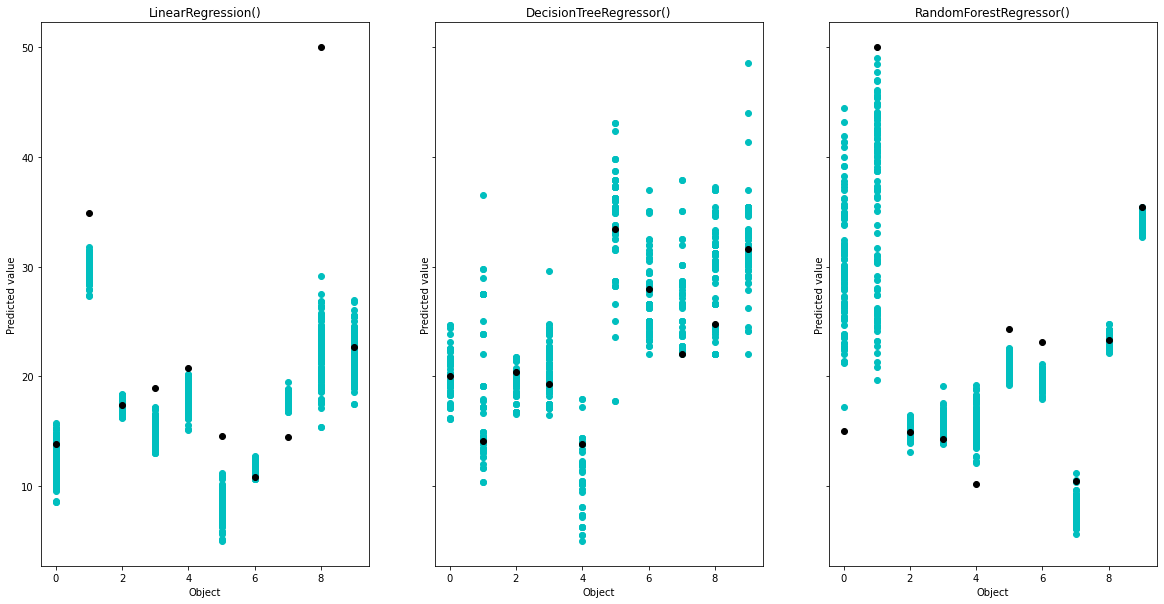

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
for i, model in enumerate(models_list):
    plot_predictions(model, X, y, ax[i], num_runs=100, num_test_objects=10, title=model)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
У линейной модели малый разброс (variance) - она устойчива к изменениям в обучающей выборке, поэтому точки, полученные в результате обучения нескольких базовых моделей дают близкие ответы, лежат близко друг к другу и образуют целые линии. Смещение (bias) линейной регрессии велико - предсказания далеки от ответов, чаще всего ответы либо не попадают в "линию предсказаний", либо находятся на краю линии предсказанных ответов - модель не отражает реальную зависимость.

У решающих деревьев самый большой разброс (variance), точки менее сгруппированы в одном и том же месте, что означает, что модель не устойчива к изменениям обучающей выборки, подстраивается под данные в том числе под выбросы. Смещение (bias) у решающих деревьев не так велико как у линейной регрессии, зависимость описывается хорошо, а ответы попадают внутрь линии предсказанных значений.

Разброс случайного леса в среднем меньше решающих деревьев, точки более сгруппированы. Разброс похож на что-то промежуточное между деревьями и линейной регрессией. Смещение алгоритма больше, чем у деревьев, зависимость не очень хорошо описывает реальные данные - реальные ответы не попадают в линии предсказаний, либо находятся на краю.


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [71]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_features = np.arange(1, X.shape[1])
n_estimators = 2**np.arange(1, 11)
list(n_estimators)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

#### Decision Tree - max_features, Max Depth

In [98]:
bias_list = []
variance_list= []
for features in max_features:
    tree = DecisionTreeRegressor(max_features=features)
    bias, variance, error = compute_biase_variance(tree, X, y, num_runs=100)    
    bias_list.append(bias)
    variance_list.append(variance)

In [99]:
feature_dependecy = pd.DataFrame(index=max_features)
feature_dependecy['bias'] = bias_list
feature_dependecy['varince'] = variance_list

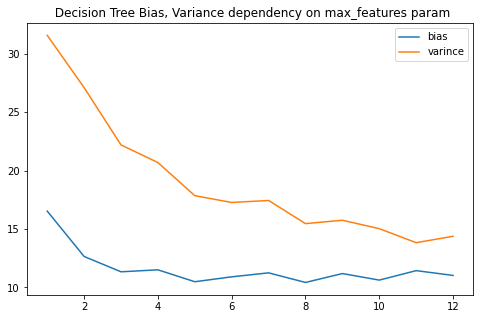

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(feature_dependecy.index, feature_dependecy['bias'], label='bias')
plt.plot(feature_dependecy.index, feature_dependecy['varince'], label='varince')
plt.title(' Decision Tree Bias, Variance dependency on max_features param')
plt.legend();

###  Комментарии. 
Чем больше max_features, тем ниже разброс модели. Получается, что если у нас есть возможность выбирать из большего количества признаков при построении вершины дерева, мы можем создать более устойчивую модель (variance мал), смещение практически не меняется после max_features = 3.

In [101]:
bias_list = list()
variance_list= list()
for depth in max_depth:
    tree = DecisionTreeRegressor(max_depth=depth)
    bias, variance, error = compute_biase_variance(tree, X, y, num_runs=100)
    bias_list.append(bias)
    variance_list.append(variance)

depth_dependecy = pd.DataFrame(index=max_depth)
depth_dependecy['bias'] = bias_list
depth_dependecy['varince'] = variance_list

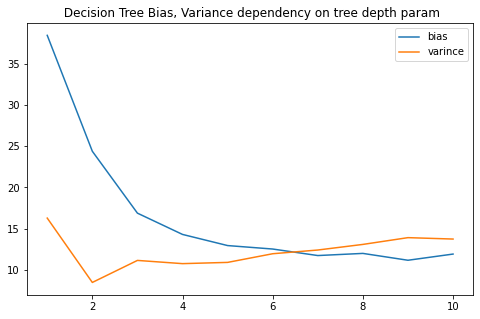

In [102]:
plt.figure(figsize=(8, 5))
plt.plot(depth_dependecy.index, depth_dependecy['bias'], label='bias')
plt.plot(depth_dependecy.index, depth_dependecy['varince'], label='varince')
plt.title(' Decision Tree Bias, Variance dependency on tree depth param')
plt.legend();

### Комментарий
Если будем увеличивать глубину деревьев, величина смещения средней модели относительно ответов выйдет на плато и не будет меняться, в то время как разброс моделей будет увеличиваться. Это происходит по причине переобучения алгоритмов уже после глубины дерева = 5, модели подстраиваются под выбросы обучающей выборки.

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

### Random Forest n_estimators
Тут у меня возникли проблемы обсчитать весь разброс значений n_estimators. Количество значений для быстроты расчета пришлось сократить

In [103]:
n_estimators = 2**np.arange(1, 8)

bias_list = []
variance_list = []
for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator)
    bias, variance, error = compute_biase_variance(rf, X, y, num_runs=100)
    bias_list.append(bias)
    variance_list.append(variance)

In [104]:
estimator_dependecy = pd.DataFrame(index=n_estimators)
estimator_dependecy['bias'] = bias_list
estimator_dependecy['varince'] = variance_list

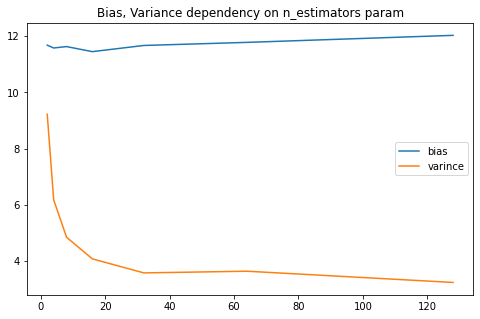

In [110]:
plt.figure(figsize=(8, 5))
plt.plot(estimator_dependecy.index, estimator_dependecy['bias'], label='bias')
plt.plot(estimator_dependecy.index, estimator_dependecy['varince'], label='varince')
plt.title('Bias, Variance dependency on n_estimators param')
plt.legend();

### Комментарий 
Смещение (bias) ансамбля решающих деревьев практически не изменяется при увеличении числа деревьев. Смещение всей модели будет примерно равно смещению базовый модели. Разброс случайного леса падает при росте числа деревьев, это происходит по причине увеличения N, который в формуле стоит в знаменателе компонент разброса.

In [106]:
from sklearn.ensemble import GradientBoostingRegressor
n_estimators = 2**np.arange(1, 8)

In [107]:
bias_list = []
variance_list = []
for estimator in n_estimators:
    gb = GradientBoostingRegressor(n_estimators=estimator)
    bias, variance, error = compute_biase_variance(gb, X, y, num_runs=100)
    bias_list.append(bias)
    variance_list.append(variance)

In [108]:
gb_estimator_dependecy = pd.DataFrame(index=n_estimators)
gb_estimator_dependecy['bias'] = bias_list
gb_estimator_dependecy['varince'] = variance_list

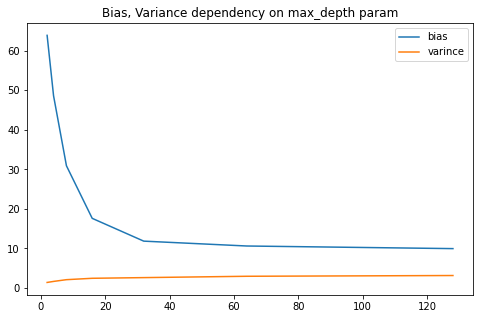

In [109]:
plt.figure(figsize=(8, 5))
plt.plot(gb_estimator_dependecy.index, gb_estimator_dependecy['bias'], label='bias')
plt.plot(gb_estimator_dependecy.index, gb_estimator_dependecy['varince'], label='varince')
plt.title('Bias, Variance dependency on max_depth param')
plt.legend();

In [112]:
 gb_estimator_dependecy['varince']

2      1.41
4      1.67
8      2.11
16     2.46
32     2.63
64     2.97
128    3.16
Name: varince, dtype: float64

### Комментарий

Как упоминалось в лекциях, в градиентном бустинге смещение падает, а разброс растет. На графике разброс растет очень медленно, возможно, это связано с методом бэггинга, которым я пользуюсь при подсчете смещения и разброса.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

In [88]:
from PIL import Image

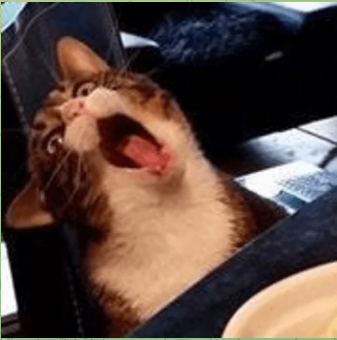

In [94]:
img = Image.open('1.png')
img